<a href="https://colab.research.google.com/github/AryaJeet1364/QuantumComputing/blob/main/QuantumTeleportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quantum Teleportation

In [1]:
!pip install qiskit -q
!pip install qiskit[visualization] -q
import qiskit as qk

!pip install qiskit-aer -q
import qiskit_aer as qk_aer

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import qiskit as qk
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
from math import pi

In [3]:
import numpy as np

In [4]:
def quantum_teleportation():
    """
    Complete implementation of quantum teleportation protocol using Qiskit.

    The quantum teleportation protocol allows us to transfer the quantum state of
    one qubit to another qubit at a distant location, using entanglement and
    classical communication. The original qubit's state is destroyed in the process.

    Protocol overview:
    1. Create an unknown quantum state |ψ⟩ to be teleported
    2. Create an entangled Bell pair between Alice and Bob
    3. Alice performs a Bell measurement on her qubit and the state to teleport
    4. Alice sends classical bits to Bob based on measurement results
    5. Bob applies corrections based on Alice's classical bits
    6. The original state is now teleported to Bob's qubit
    """

    # Create quantum and classical registers
    # We need 3 qubits: one for the state to teleport, and two for the Bell pair
    qreg = QuantumRegister(3, 'q')
    creg = ClassicalRegister(3, 'c')  # Classical bits to store measurement results

    # Create the quantum circuit
    qc = QuantumCircuit(qreg, creg)

    # === STEP 1: Prepare the unknown state |ψ⟩ to be teleported ===
    # For demonstration, we'll create a superposition state: α|0⟩ + β|1⟩
    # Let's use specific values: |ψ⟩ = (1/√2)|0⟩ + (i/√2)|1⟩
    # This is equivalent to applying RY(π/2) followed by a phase gate

    qc.ry(np.pi/2, qreg[0])  # Rotate around Y-axis to create superposition
    qc.s(qreg[0])            # Apply S gate (phase gate) to add phase

    # Add a barrier for visual clarity in the circuit diagram
    qc.barrier()

    # === STEP 2: Create entangled Bell pair between Alice (q1) and Bob (q2) ===
    # The Bell state we create is |Φ+⟩ = (1/√2)(|00⟩ + |11⟩)
    # This is the maximally entangled state that enables teleportation

    qc.h(qreg[1])           # Apply Hadamard to qubit 1 (Alice's part of Bell pair)
    qc.cx(qreg[1], qreg[2]) # CNOT gate creates entanglement between Alice and Bob

    qc.barrier()

    # === STEP 3: Alice's Bell measurement ===
    # Alice now has two qubits: the original state |ψ⟩ (q0) and her part of
    # the Bell pair (q1). She performs a Bell state measurement on these two qubits.
    # This measurement projects the two-qubit system onto one of the four Bell states.

    # First, apply CNOT with the original state as control and Alice's Bell qubit as target
    qc.cx(qreg[0], qreg[1])

    # Then apply Hadamard to the original state qubit
    qc.h(qreg[0])

    qc.barrier()

    # === STEP 4: Alice measures her qubits and gets classical bits ===
    # The measurement results will determine what correction Bob needs to apply
    # There are 4 possible outcomes (00, 01, 10, 11), each occurring with 25% probability

    qc.measure(qreg[0], creg[0])  # Measure original state qubit
    qc.measure(qreg[1], creg[1])  # Measure Alice's Bell pair qubit

    qc.barrier()

    # === STEP 5: Bob applies corrections based on Alice's measurement results ===
    # Based on Alice's classical bits, Bob needs to apply specific gates to recover |ψ⟩
    # - If Alice measured 00: Bob does nothing (identity operation)
    # - If Alice measured 01: Bob applies X gate (bit flip)
    # - If Alice measured 10: Bob applies Z gate (phase flip)
    # - If Alice measured 11: Bob applies both X and Z gates

    # These are conditional operations based on classical measurement results
    # In modern Qiskit, we add conditional gates using the circuit method with condition parameter
    with qc.if_test((creg[1], 1)):  # If Alice's second measurement result is 1
        qc.x(qreg[2])  # Apply X gate to Bob's qubit

    with qc.if_test((creg[0], 1)):  # If Alice's first measurement result is 1
        qc.z(qreg[2])  # Apply Z gate to Bob's qubit


    qc.barrier()

    # === STEP 6: Measure Bob's qubit to verify the teleportation ===
    # At this point, Bob's qubit should be in the same state as the original |ψ⟩
    qc.measure(qreg[2], creg[2])

    return qc

In [5]:
def verify_teleportation():
    """
    Verify that quantum teleportation worked by comparing the probability
    distributions of the original state and the teleported state.
    """

    # Create the teleportation circuit
    teleport_circuit = quantum_teleportation()

    # Also create a reference circuit with just the original state preparation
    # This will help us verify that the teleportation preserved the state
    qreg_ref = QuantumRegister(1, 'q_ref')
    creg_ref = ClassicalRegister(1, 'c_ref')
    reference_circuit = QuantumCircuit(qreg_ref, creg_ref)

    # Prepare the same state as in the teleportation protocol
    reference_circuit.ry(np.pi/2, qreg_ref[0])
    reference_circuit.s(qreg_ref[0])
    reference_circuit.measure(qreg_ref[0], creg_ref[0])

    # Set up the simulator
    simulator = AerSimulator()

    # Run both circuits multiple times to get statistics
    shots = 8192

    # Execute the teleportation circuit
    teleport_job = simulator.run(transpile(teleport_circuit, simulator), shots=shots)
    teleport_result = teleport_job.result()
    teleport_counts = teleport_result.get_counts()

    # Execute the reference circuit
    ref_job = simulator.run(transpile(reference_circuit, simulator), shots=shots)
    ref_result = ref_job.result()
    ref_counts = ref_result.get_counts()

    # Extract the relevant measurement results
    # For teleportation: we care about the last bit (Bob's final measurement)
    # For reference: we care about the single measurement result

    teleport_final_counts = {'0': 0, '1': 0}
    for outcome, count in teleport_counts.items():
        # Extract Bob's final measurement (rightmost bit)
        bob_result = outcome[-1]
        teleport_final_counts[bob_result] += count

    print("=== Quantum Teleportation Verification ===")
    print(f"\nOriginal state measurement results ({shots} shots):")
    print(f"  |0⟩: {ref_counts.get('0', 0)} times ({ref_counts.get('0', 0)/shots*100:.1f}%)")
    print(f"  |1⟩: {ref_counts.get('1', 0)} times ({ref_counts.get('1', 0)/shots*100:.1f}%)")

    print(f"\nTeleported state measurement results ({shots} shots):")
    print(f"  |0⟩: {teleport_final_counts['0']} times ({teleport_final_counts['0']/shots*100:.1f}%)")
    print(f"  |1⟩: {teleport_final_counts['1']} times ({teleport_final_counts['1']/shots*100:.1f}%)")

    # Calculate the fidelity (how close the distributions are)
    p0_orig = ref_counts.get('0', 0) / shots
    p1_orig = ref_counts.get('1', 0) / shots
    p0_teleport = teleport_final_counts['0'] / shots
    p1_teleport = teleport_final_counts['1'] / shots

    # Fidelity for probability distributions
    fidelity = np.sqrt(p0_orig * p0_teleport) + np.sqrt(p1_orig * p1_teleport)

    print(f"\nFidelity of teleportation: {fidelity:.4f}")
    print("(Perfect teleportation would have fidelity = 1.0)")

    # Show detailed breakdown of all measurement outcomes in teleportation
    print(f"\nDetailed teleportation measurement outcomes:")
    print("Format: Alice_bit0 Alice_bit1 Bob_final_bit -> count")
    for outcome, count in sorted(teleport_counts.items()):
        percentage = count/shots*100
        print(f"  {outcome} -> {count:4d} times ({percentage:5.1f}%)")

    return teleport_circuit, teleport_counts, ref_counts


In [6]:
def visualize_circuit():
    """
    Create and display the quantum teleportation circuit diagram.
    """
    circuit = quantum_teleportation()

    print("=== Quantum Teleportation Circuit ===")

    # Display the circuit using matplotlib with Clifford style
    from IPython.display import display
    display(circuit.draw('mpl', style='clifford', scale=1))

    return circuit

In [7]:
# === THEORETICAL EXPLANATION ===
def explain_teleportation_theory():
    """
    Detailed theoretical explanation of quantum teleportation.
    """

    print("=== Quantum Teleportation: Theoretical Foundation ===\n")

    print("1. THE IMPOSSIBILITY OF CLONING:")
    print("   Quantum mechanics forbids perfect cloning of arbitrary quantum states")
    print("   (No-cloning theorem). Teleportation doesn't clone - it transfers the state.\n")

    print("2. ENTANGLEMENT AS A RESOURCE:")
    print("   Alice and Bob share a maximally entangled Bell pair: |Φ+⟩ = (|00⟩ + |11⟩)/√2")
    print("   This shared entanglement is the 'quantum channel' that enables teleportation.\n")

    print("3. THE TELEPORTATION PROTOCOL:")
    print("   Initial state: |ψ⟩⊗|Φ+⟩ = (α|0⟩ + β|1⟩) ⊗ (|00⟩ + |11⟩)/√2")
    print("   After Alice's Bell measurement, the combined state collapses into one of")
    print("   four equally probable outcomes, each leaving Bob's qubit in a related state.\n")

    print("4. MEASUREMENT OUTCOMES AND CORRECTIONS:")
    print("   Alice's measurement | Bob's state | Required correction")
    print("   ------------------|-------------|------------------")
    print("         00         |     |ψ⟩     |    Identity (I)")
    print("         01         |    X|ψ⟩     |    Pauli-X")
    print("         10         |    Z|ψ⟩     |    Pauli-Z")
    print("         11         |   XZ|ψ⟩     |    Pauli-X then Z\n")

    print("5. CLASSICAL COMMUNICATION:")
    print("   Alice must send her 2-bit measurement result to Bob classically.")
    print("   Without this information, Bob cannot complete the teleportation.")
    print("   This preserves causality - no faster-than-light communication!\n")

    print("6. STATE DESTRUCTION:")
    print("   The original qubit's state is destroyed during Alice's measurement.")
    print("   This is fundamental - the state is moved, not copied.\n")

=== Quantum Teleportation: Theoretical Foundation ===

1. THE IMPOSSIBILITY OF CLONING:
   Quantum mechanics forbids perfect cloning of arbitrary quantum states
   (No-cloning theorem). Teleportation doesn't clone - it transfers the state.

2. ENTANGLEMENT AS A RESOURCE:
   Alice and Bob share a maximally entangled Bell pair: |Φ+⟩ = (|00⟩ + |11⟩)/√2
   This shared entanglement is the 'quantum channel' that enables teleportation.

3. THE TELEPORTATION PROTOCOL:
   Initial state: |ψ⟩⊗|Φ+⟩ = (α|0⟩ + β|1⟩) ⊗ (|00⟩ + |11⟩)/√2
   After Alice's Bell measurement, the combined state collapses into one of
   four equally probable outcomes, each leaving Bob's qubit in a related state.

4. MEASUREMENT OUTCOMES AND CORRECTIONS:
   Alice's measurement | Bob's state | Required correction
   ------------------|-------------|------------------
         00         |     |ψ⟩     |    Identity (I)
         01         |    X|ψ⟩     |    Pauli-X
         10         |    Z|ψ⟩     |    Pauli-Z
         11    

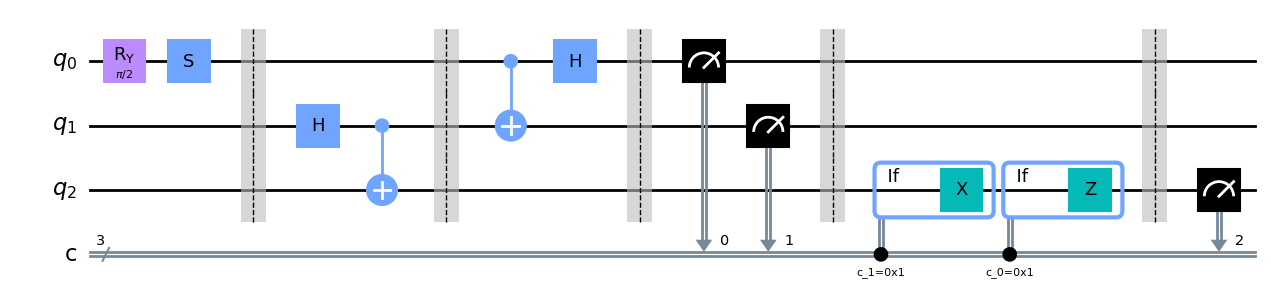


=== Quantum Teleportation Verification ===

Original state measurement results (8192 shots):
  |0⟩: 4030 times (49.2%)
  |1⟩: 4162 times (50.8%)

Teleported state measurement results (8192 shots):
  |0⟩: 4137 times (50.5%)
  |1⟩: 4055 times (49.5%)

Fidelity of teleportation: 0.9999
(Perfect teleportation would have fidelity = 1.0)

Detailed teleportation measurement outcomes:
Format: Alice_bit0 Alice_bit1 Bob_final_bit -> count
  000 -> 1067 times ( 13.0%)
  001 -> 1001 times ( 12.2%)
  010 -> 1018 times ( 12.4%)
  011 -> 1021 times ( 12.5%)
  100 -> 1023 times ( 12.5%)
  101 -> 1020 times ( 12.5%)
  110 -> 1029 times ( 12.6%)
  111 -> 1013 times ( 12.4%)

=== Key Insights ===
• Quantum teleportation successfully transfers quantum information
• The protocol requires both quantum entanglement and classical communication
• No information travels faster than light (respects relativity)
• The original state is destroyed (no cloning)
• Perfect fidelity is achieved in the absence of noise


In [8]:
# === MAIN EXECUTION ===
if __name__ == "__main__":
    # Provide theoretical background
    explain_teleportation_theory()

    # Show the circuit diagram
    circuit = visualize_circuit()

    # Run the teleportation and verify it worked
    print("\n" + "="*60)
    teleport_circuit, teleport_counts, ref_counts = verify_teleportation()

    print("\n" + "="*60)
    print("=== Key Insights ===")
    print("• Quantum teleportation successfully transfers quantum information")
    print("• The protocol requires both quantum entanglement and classical communication")
    print("• No information travels faster than light (respects relativity)")
    print("• The original state is destroyed (no cloning)")
    print("• Perfect fidelity is achieved in the absence of noise")
    print("• This forms the basis for quantum communication networks")